In [1]:
import os
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

logs_dir = '/coc/flash5/mpatel377/repos/SLaTe-PRO/logs_0810/RoboCraft/default_100'

/tmp/ipykernel_4115879/3513344496.py:3: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [5]:
config = json.load(open(os.path.join(logs_dir, 'config.json')))
results = {'epochs':[], 'precision': [], 'recall': [], 'f1': []}

for epoch in config['epochs']:
    json_file = os.path.join(logs_dir, f'Epoch{epoch}_test_evaluation_splits.json')
    with open(json_file, 'r') as f:
        data = json.load(f)
    results['epochs'].append(epoch)
    for key in results.keys():
        if key == 'epochs': continue
        results[key].append(data[key])

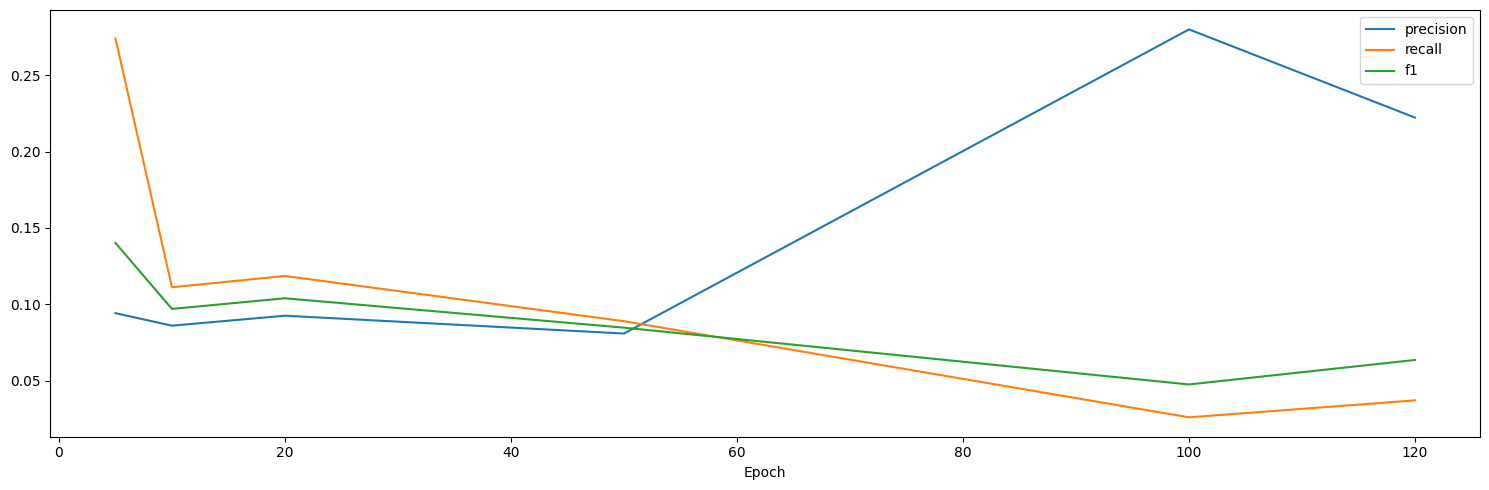

In [14]:
fig, ax = plt.subplots(1, 1, figsize=(15, 5))

for i, key in enumerate(results.keys()):
    if key == 'epochs': continue
    ax.plot(results['epochs'], results[key], label=key)
    ax.set_xlabel('Epoch')

ax.legend()
plt.tight_layout()
plt.show()